In [1]:
import os
import time
import numpy as np
import imageio 
import json

In [2]:
trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],]).astype(np.float32)
#trans_t(1)

In [3]:
rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],]).astype(np.float32)
#rot_phi(0.1)

In [4]:
rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],]).astype(np.float32)
#rot_theta(0.2)

In [5]:
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

In [6]:
import cv2
def load_blender_data(basedir, half_res=False, testskip=1):
    splits = ['train', 'val', 'test']
    metas = {}
    for s in splits:
        with open(os.path.join(basedir, 'transforms_{}.json'.format(s)), 'r') as fp:
            metas[s] = json.load(fp)

    all_imgs = []
    all_poses = []
    counts = [0]
    for s in splits:
        meta = metas[s]
        imgs = []
        poses = []
        if s=='train' or testskip==0:
            skip = 1
        else:
            skip = testskip
            
        for frame in meta['frames'][::skip]:
            fname = os.path.join(basedir, frame['file_path'] + '.png')
            img_frame = imageio.imread(fname)
            if half_res:
                img_frame = cv2.resize(img_frame, (400,400))
            imgs.append(img_frame)
            poses.append(np.array(frame['transform_matrix']))
        imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        counts.append(counts[-1] + imgs.shape[0])
        all_imgs.append(imgs)
        all_poses.append(poses)
    
    i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)]
    
    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)
    
    H, W = imgs[0].shape[:2]
    camera_angle_x = float(meta['camera_angle_x'])
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    
    render_poses = np.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]],0)

    return imgs, poses, render_poses, [H, W, focal], i_split

In [7]:
datadir = './data/nerf_synthetic/lego'
half_res = True
testskip = 8
images, poses, render_poses, hwf, i_split = load_blender_data(datadir, half_res, testskip)
print('Loaded blender', images.shape, render_poses.shape, hwf, datadir)
i_split

Loaded blender (138, 400, 400, 4) (40, 4, 4) [400, 400, 555.5555155968841] ./data/nerf_synthetic/lego


[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]),
 array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137])]

In [8]:
white_bkgd = True
near = 2.
far = 6.

if white_bkgd:
    images = images[..., :3]*images[..., -1:] + (1.-images[..., -1:])
else:
    images = images[..., :3]

(138, 400, 400, 3) (138, 4, 4) 555.5555155968841
target pose:
[[ 0.5004437   0.559553   -0.66064847 -2.6631594 ]
 [-0.86576915  0.3234405  -0.38187703 -1.5393958 ]
 [ 0.          0.763077    0.6463074   2.6053488 ]
 [ 0.          0.          0.          1.        ]]


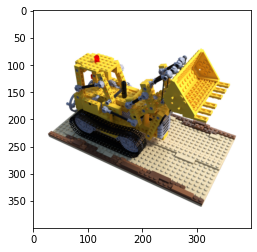

In [10]:
import matplotlib.pyplot as plt

H, W, focal = hwf
print(images.shape, poses.shape, focal)
#show test photo (8nd)
testimg, testpose = images[107], poses[107]
print('target pose:')
print(poses[107])
plt.imshow(testimg)
plt.show()

In [34]:
class Embedder:

    def __init__(self, **kwargs):

        self.kwargs = kwargs
        self.create_embedding_fn()

    def create_embedding_fn(self):

        embed_fns = []
        d = self.kwargs['input_dims']
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x: x)
            out_dim += d

        max_freq = self.kwargs['max_freq_log2']
        N_freqs = self.kwargs['num_freqs']

        if self.kwargs['log_sampling']:
            freq_bands = 2.**np.linspace(0., max_freq, N_freqs, dtype=np.float32)
        else:
            freq_bands = np.linspace(2.**0., 2.**max_freq, N_freqs, dtype=np.float32)

        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn,
                                 freq=freq: p_fn(x * freq))
                out_dim += d

        self.embed_fns = embed_fns
        self.out_dim = out_dim

    def embed(self, inputs):
        return np.concatenate([fn(inputs) for fn in self.embed_fns], -1).astype(np.float32)


In [17]:
def get_embedder(multires, i=0):
    embed_kwargs = {
        'include_input': True,
        'input_dims': 3,
        'max_freq_log2': multires-1,
        'num_freqs': multires,
        'log_sampling': True,
        'periodic_fns': [np.sin, np.cos],
    }

    embedder_obj = Embedder(**embed_kwargs)
    def embed(x, eo=embedder_obj): 
        return eo.embed(x)
    return embed, embedder_obj.out_dim


In [35]:
multires = 10
multires_views = 4
i_embed = 0
embed_fn, input_ch = get_embedder(multires, i_embed)
embeddirs_fn, input_ch_views = get_embedder(multires_views, i_embed)
print(input_ch, input_ch_views)

63 27


In [36]:
# load models
from openvino.runtime import Core

ie = Core()
model_xml = "./logs/lego_test/saved_300000/xml/saved_model.xml"
model = ie.read_model(model=model_xml)
network_fn = ie.compile_model(model=model, device_name="CPU")

model_xml_fine = "./logs/lego_test/saved_fine_300000/xml/saved_model.xml"
model = ie.read_model(model=model_xml_fine)
network_fine = ie.compile_model(model=model, device_name="CPU")


In [75]:
def run_network(inputs, viewdirs, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    """Prepares inputs and applies network 'fn'."""
    inputs_flat = np.reshape(inputs, [-1, inputs.shape[-1]])

    embedded = embed_fn(inputs_flat)
    if viewdirs is not None:
        input_dirs = np.broadcast_to(viewdirs[:, None], inputs.shape)
        input_dirs_flat = np.reshape(input_dirs, [-1, input_dirs.shape[-1]])
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        embedded = np.concatenate([embedded, embedded_dirs], -1)
    print('embedded dtype', embedded.dtype)
    outputs_flat = batchify(fn, netchunk)(embedded)
    outputs = np.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    return outputs

In [48]:
def network_query_fn(inputs, viewdirs, network_fn): 
    return run_network( inputs, 
                        viewdirs, 
                        network_fn,
                        embed_fn=embed_fn,
                        embeddirs_fn=embeddirs_fn,
                        netchunk=1024*64)

In [109]:
render_kwargs = {
    'network_query_fn': network_query_fn,
    'perturb': 0,
    'N_samples': 64,
    'N_importance':64,
    'network_fn': network_fn,
    'network_fine': network_fine,
    'white_bkgd': True,
    'raw_noise_std':0,
}

In [50]:
def sample_pdf(bins, weights, N_samples, det=False):

    # Get pdf
    weights += 1e-5  # prevent nans
    pdf = weights / np.sum(weights, axis=-1, keepdims=True)
    cdf = np.cumsum(pdf, -1)
    cdf = np.concatenate([np.zeros_like(cdf[..., :1]), cdf], -1)

    # Take uniform samples
    if det:
        u = np.linspace(0., 1., N_samples, dtype=np.float32)
        u = np.broadcast_to(u, list(cdf.shape[:-1]) + [N_samples])
    else:
        u = np.random.uniform(list(cdf.shape[:-1]) + [N_samples],  dtype=np.float32)

    # Invert CDF
    inds = np.searchsorted(cdf, u, side='right')
    below = np.maximum(0, inds-1)
    above = np.minimum(cdf.shape[-1]-1, inds)
    inds_g = np.stack([below, above], -1)
    cdf_g = np.gather(cdf, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    bins_g = np.gather(bins, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)

    denom = (cdf_g[..., 1]-cdf_g[..., 0])
    denom = np.where(denom < 1e-5, np.ones_like(denom), denom)
    t = (u-cdf_g[..., 0])/denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1]-bins_g[..., 0])

    return samples


In [125]:
def render_rays(ray_batch, network_fn, network_query_fn, N_samples,  retraw=False,
                lindisp=False, perturb=0., N_importance=0, network_fine=None,
                white_bkgd=False, raw_noise_std=0., verbose=False):
    def raw2outputs(raw, z_vals, rays_d):
        # strictly between [0, 1].
        
        def ReLU(x):
            return x * (x > 0)
        def Sigmoid(x):
            return  1/(1 + np.exp(-x)) 
        
        def raw2alpha(raw, dists, act_fn=ReLU): 
            return 1.0 - np.exp(-act_fn(raw) * dists)

        # Compute 'distance' (in time) between each integration time along a ray.
        dists = (z_vals[..., 1:] - z_vals[..., :-1]).astype(np.float32)

        dists = np.concatenate([dists, np.broadcast_to([1e10], dists[..., :1].shape)], axis=-1)  # [N_rays, N_samples]
        dists = dists * np.linalg.norm(rays_d[..., None, :], axis=-1).astype(np.float32)

        # Extract RGB of each sample position along each ray.
        rgb = Sigmoid(raw[..., :3]).astype(np.float32)  # [N_rays, N_samples, 3]
        alpha = raw2alpha(raw[..., 3], dists).astype(np.float32)  # [N_rays, N_samples]
        
        # Compute weight for RGB of each sample along each ray.  A cumprod() is
        # used to express the idea of the ray not having reflected up to this
        # sample yet.
        # [N_rays, N_samples]
        weights = alpha * np.cumprod(1.-alpha + 1e-10, axis=-1, dtype=np.float32)
        # Computed weighted color of each sample along each ray.
        rgb_map = np.sum(weights[..., None] * rgb, axis=-2)  # [N_rays, 3]

        # Sum of weights along each ray. This value is in [0, 1] up to numerical error.
        acc_map = np.sum(weights, axis=-1)

        # To composite onto a white background, use the accumulated alpha map.
        if white_bkgd:
            rgb_map = rgb_map + (1.-acc_map[..., None])

        return rgb_map, weights

    ###############################
    # batch size
    N_rays = ray_batch.shape[0]
    
    # Extract ray origin, direction.
    rays_o, rays_d = ray_batch[:, 0:3], ray_batch[:, 3:6]  # [N_rays, 3] each

    # Extract unit-normalized viewing direction.
    viewdirs = ray_batch[:, -3:] if ray_batch.shape[-1] > 8 else None

    # Extract lower, upper bound for ray distance.
    bounds = np.reshape(ray_batch[..., 6:8], [-1, 1, 2])
    near, far = bounds[..., 0], bounds[..., 1]  # [-1,1]
    
    # Decide where to sample along each ray. Under the logic, all rays will be sampled at
    # the same times.
    t_vals = np.linspace(0., 1., N_samples, dtype=np.float32)
    
    # Space integration times linearly between 'near' and 'far'. Same
    # integration points will be used for all rays.
    z_vals = near * (1.-t_vals) + far * (t_vals)
    z_vals = np.broadcast_to(z_vals, [N_rays, N_samples])
        
    # Perturb sampling time along each ray.
    if perturb > 0.:
        # get intervals between samples
        mids = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        upper = np.concatenate([mids, z_vals[..., -1:]], -1)
        lower = np.concatenate([z_vals[..., :1], mids], -1)
        # stratified samples in those intervals
        t_rand = np.random.uniform(z_vals.shape)
        z_vals = lower + (upper - lower) * t_rand

    # Points in space to evaluate model at.
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]  # [N_rays, N_samples, 3]

    # Evaluate model at each point.
    raw = network_query_fn(pts, viewdirs, network_fn)  # [N_rays, N_samples, 4]
    print('raw out', raw.shape)
    rgb_map, weights = raw2outputs(raw, z_vals, rays_d)
    N_importance = 0
    if N_importance > 0:
        # Obtain additional integration times to evaluate based on the weights
        # assigned to colors in the coarse model.
        z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], N_importance, det=(perturb == 0.))

        # Obtain all points to evaluate color, density at.
        z_vals = np.sort(np.concatenate([z_vals, z_samples], -1), -1)
        pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]  # [N_rays, N_samples + N_importance, 3]

        # Make predictions with network_fine.
        run_fn = network_fn if network_fine is None else network_fine
        raw = network_query_fn(pts, viewdirs, run_fn)
        rgb_map, _ = raw2outputs(raw, z_vals, rays_d)

    return rgb_map

In [104]:
def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """Render rays in smaller minibatches to avoid OOM."""
    rets = []
    print('rays_flat', rays_flat.shape)
    for i in range(0, rays_flat.shape[0], chunk):
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        rets.append(ret)
    return np.concatenate(rets, 0)


In [89]:
def get_rays(H, W, focal, c2w):
    """Get ray origins, directions from a pinhole camera."""
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    rays_o = np.broadcast_to(c2w[:3, -1], np.shape(rays_d))
    return rays_o, rays_d

In [90]:
#Render ray batch (whole image)
def render(H, W, focal, chunk=1024*32, rays=None, c2w=None, ndc=True, near=2., far=6., **kwargs):

    rays_o, rays_d = get_rays(H, W, focal, c2w)
    viewdirs = rays_d

    # Make all directions unit magnitude.
    # shape: [batch_size, 3]
    viewdirs = viewdirs / np.linalg.norm(viewdirs, axis=-1, keepdims=True)
    viewdirs = np.reshape(viewdirs, [-1, 3]).astype(np.float32)   
    
    # Create ray batch
    rays_o = np.reshape(rays_o, [-1, 3]).astype(np.float32)  
    rays_d = np.reshape(rays_d, [-1, 3]).astype(np.float32)  
    near, far = near * np.ones_like(rays_d[..., :1]), far * np.ones_like(rays_d[..., :1])
    
    # (ray origin, ray direction, min dist, max dist, normalized viewing direction) for each ray
    rays = np.concatenate([rays_o, rays_d, near, far], axis=-1)
    rays = np.concatenate([rays, viewdirs], axis=-1)
    
    # Render and reshape
    rgb_map = batchify_rays(rays, chunk, **kwargs)
    out_shape = list(rays_d.shape[:-1]) + list(rgb_map.shape[1:])
    return np.reshape(rgb_map, out_shape)
        

In [133]:
def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches."""
    if chunk is None:
        return fn

    def ret(inputs):
        #return np.concatenate([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0).astype(np.float32)
        print(inputs.shape, inputs.dtype)
        t = time.time()
        request = fn.create_infer_request()
        input_layer = fn.inputs[0]
        output_layer = fn.outputs[0]
        rets = []
        for i in range(0, inputs.shape[0], chunk):
            request.infer(inputs={input_layer.any_name: inputs[i:i+chunk]})
            data = request.get_output_tensor(output_layer.index).data
            rets.append(data)
        print('inference time', time.time()-t)
        return np.concatenate(rets, 0)
    return ret

In [134]:
index=107
testimg, testpose = images[index], poses[index]
print('test poses shape', poses[107].shape)
t = time.time()
rgb_map = render(H, W, focal, chunk=1024*32, c2w=testpose[:3, :4], **render_kwargs)
print(time.time()-t, 'secs')
rgb_map = np.reshape(rgb_map, list(testimg.shape[:-1]) + [3])
print(rgb_map.shape, rgb_map.dtype)

test poses shape (4, 4)
rays_flat (160000, 11)
embedded dtype float32
(2097152, 90) float32
inference time 12.724636554718018
raw out (32768, 64, 4)
embedded dtype float32
(2097152, 90) float32
inference time 13.038920640945435
raw out (32768, 64, 4)
embedded dtype float32
(2097152, 90) float32
inference time 12.701229572296143
raw out (32768, 64, 4)
embedded dtype float32
(2097152, 90) float32
inference time 13.7055504322052
raw out (32768, 64, 4)
embedded dtype float32
(1851392, 90) float32
inference time 11.768885135650635
raw out (28928, 64, 4)
78.47343397140503 secs
(400, 400, 3) float32


In [135]:
def to8b(x): 
    return (255*np.clip(x, 0, 1)).astype(np.uint8)

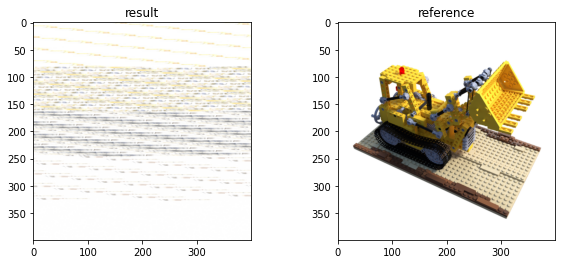

In [136]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(to8b(rgb_map))
plt.title(f'result')

plt.subplot(122)
plt.imshow(testimg)
plt.title('reference')
    
plt.show()